In [70]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib

In [71]:
df_scraped = pd.read_csv('labeled_tweets.csv')
df_public = pd.read_csv('public_data_labeled.csv')

In [72]:
df_scraped.drop_duplicates(inplace = True)
df_scraped.drop('id', axis = 'columns', inplace = True)

df_public.drop_duplicates(inplace = True)

In [73]:
df_scraped.head(2)

,label,full_text
0,Offensive,So Drasko just said he was impressed the girls...
2,Offensive,Drasko they didn't cook half a bird you idiot ...


In [74]:
df_public.head(2)

,label,full_text
0,Non-offensive,!!! RT @mayasolovely: As a woman you shouldn't...
1,Offensive,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...


In [75]:
df = pd.concat([df_scraped, df_public])

In [76]:
df.shape

(35787, 2)

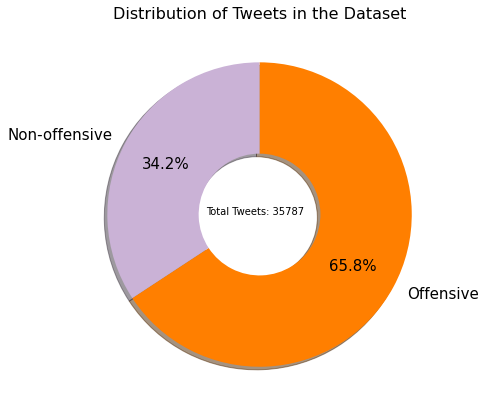

In [77]:
plt.figure(figsize = (7,7))
sorted_counts = df['label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);
plt.show()

In [78]:
df['label'] = df.label.map({'Offensive': 1, 'Non-offensive': 0})

Implementing a training and predicting Pipeline
Separate training and testing data:

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'], 
                                                    df['label'], 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 35787
Number of rows in the training set: 26840
Number of rows in the test set: 8947


In [80]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

count_vector.fit(X_train,X_test)
joblib.dump(count_vector, 'count_vect.pkl')
# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

In [81]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

In [82]:
models = [SGDClassifier()]

In [83]:
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training SGDClassifier
Training SGDClassifier finished in 0.19 sec
----------------------------------------------------


In [84]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

Tuning Hyperparameters

In [85]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions)))

In [86]:
# Dict for parameters
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.0002, 'max_iter': 3000}
Accuracy: 0.9276
F1-score: 0.9435
Precision: 0.9680
Recall: 0.9202


In [87]:
filename = 'model.pkl'
joblib.dump(clf_sgd, filename)

['model.pkl']